In [85]:
import torch
import torchvision
import torchvision.transforms as transforms

In [98]:
transform = transforms.Compose(
    [transforms.ToTensor(), 
    transforms.Normalize((.5, .5, .5),(.5, .5, .5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, 
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                      download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, 
                                        shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


torch.Size([4, 3, 32, 32])
plane  bird horse   dog


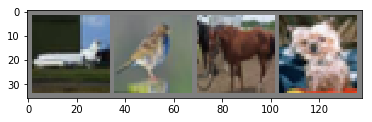

In [99]:
import matplotlib.pyplot as plt 
import numpy as np 

def imshow(img): 
    img = img / 2 + .5 
    npimg = img.numpy() 
    plt.imshow(np.transpose(npimg, (1,2,0)))
    
dataiter = iter(trainloader)
images, labels = dataiter.next() 
print(images.size())

imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [88]:
from torch.autograd import Variable 
import torch.nn as nn 
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 3 * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()             

In [89]:
print(net)

Net(
  (conv1): Conv2d (3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d (6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120)
  (fc2): Linear(in_features=120, out_features=84)
  (fc3): Linear(in_features=84, out_features=10)
)


In [90]:
# Use cross entropy loss and SGD with momentum 

import torch.optim as optim 

criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(net.parameters(), lr=.001, momentum=0.9)

In [91]:
# Train 

for epoch in range(1): 
    running_loss = 0.0 
    for i, data in enumerate(trainloader, 0):
        # Get inputs
        inputs, labels = data
        
        # Wrap in Variable 
        inputs, labels = Variable(inputs), Variable(labels)
        
        # zero the parameter gradients
        optimizer.zero_grad() 
        
        # forward + backward + optimize 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward() 
        optimizer.step() 
        
        # Print stats 
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
print('Finished Training')            

[1,  2000] loss: 2.170
[1,  4000] loss: 1.875
[1,  6000] loss: 1.713
[1,  8000] loss: 1.620
[1, 10000] loss: 1.545
[1, 12000] loss: 1.484
Finished Training


GroundTruth:    car  ship   cat truck
Predicted:  truck plane  bird truck


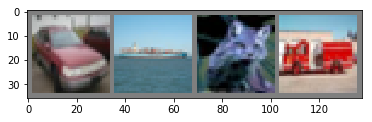

In [92]:
# Testing 
dataiter = iter(testloader)
images, labels = dataiter.next() 

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(Variable(images))
_, predicted = torch.max(outputs.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [93]:
# Accuracy on the whole dataset 
correct = 0 
total = 0 
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted==labels).sum()
    
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 48 %


In [94]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 58 %
Accuracy of   car : 53 %
Accuracy of  bird : 18 %
Accuracy of   cat : 20 %
Accuracy of  deer : 30 %
Accuracy of   dog : 42 %
Accuracy of  frog : 70 %
Accuracy of horse : 68 %
Accuracy of  ship : 56 %
Accuracy of truck : 63 %
